# PGP AI - AI and Machine Learning Capstone Project

DESCRIPTION

Problem Statement

Amazon is an online shopping website that now caters to millions of people everywhere. Over 34,000 consumer reviews for Amazon brand products like Kindle, Fire TV Stick and more are provided. 
The dataset has attributes like brand, categories, primary categories, reviews.title, reviews.text, and the sentiment. Sentiment is a categorical variable with three levels "Positive", "Negative“, and "Neutral". For a given unseen data, the sentiment needs to be predicted.
You are required to predict Sentiment or Satisfaction of a purchase based on multiple features and review text.

In [86]:
import numpy as np
import pandas as pd
import re
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def load_data(path=""):
    return pd.read_csv(path)

In [3]:
def merge_data(datasets=[]):
    return pd.concat(datasets)

In [4]:
def sample_data(data, row_count=5):
    return data[:row_count]

In [47]:
def preprocess(data):
    data = [regexp_tokenize(record, pattern='[a-z]\w+') 
                   for record in data]
    print("Completed Word Tokenization")

    data = [[word for word in text 
                    if word not in stopwords.words('english')] 
                   for text in data]
    print("Completed Removal of nltk StopWords")

    data = [[word for word in text 
                    if len(word) > 1] 
                   for text in data]
    print("Completed Removal of Words of length = 1")

    data_cleaned = []

    for record in data:
        sent = ""
        for word in record:
            sent = sent + word + " "
        data_cleaned.append(sent[:-1])

    print("Completed Joining of the cleaned Text into a record")
    
    print("Analysing Tokens:")
    token_analysis(data)
    
    return data_cleaned

In [48]:
def token_analysis(data):
    terms = []

    for record in data:
        for word in record:
            terms.append(word)

    print("Total Tokens: {}".format(len(terms)))

    from collections import Counter

    counts_terms = Counter(terms)
    terms_df = pd.DataFrame(counts_terms.most_common(10), 
                            columns=['term', 'count'])
    terms_df

    terms_df.sort_values(by='count', 
                         ascending=True).plot(kind="barh", 
                                              x='term', 
                                              figsize=(12,10), 
                                              color='teal')
    plt.show()

In [59]:
def create_dataset(data, features, label):
    X = data[features].tolist()
    y = data[label].tolist()
    return X, y

In [9]:
def resample_dataset(X, y, sampler):
    return sampler.fit_sample(X, y)

In [10]:
def create_train_test_datasets(X, y):
    from sklearn.model_selection import train_test_split

    return train_test_split(X, y, test_size=0.3, random_state = 42)

In [11]:
def create_model(X, y, model):
    return model.fit(X, y)

In [12]:
def assess_models_scores(models, X_test, y_test):
    for model in models:
        scores.add(model.name, model.f1_score(X_test, y_test))
    return scores

In [13]:
create_environment()

In [16]:
train_df = load_data("datasets/train_data.csv")
test_data_hidden_df = load_data("datasets/test_data_hidden.csv")
test_df = load_data("datasets/test_data.csv")

In [17]:
merge_df = merge_data([train_df,test_data_hidden_df])

In [18]:
sample_data(merge_df,10)

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive
5,"Kindle E-reader - White, 6 Glare-Free Touchscr...",Amazon,"Office,eBook Readers,Electronics Features,Walm...","Office Supplies,Electronics",2016-12-23T00:00:00.000Z,This is a great product. Light weight. I wish ...,You will love it,Positive
6,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-05-31T00:00:00.000Z,My 7-year old daughter saved up to by this. He...,OK For Entry Level Tablet,Neutral
7,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2016-06-05T00:00:00.000Z,Purchased this for my son. Has room to upgrade...,Great for kids or smaller needs,Positive
8,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-11-23T00:00:00.000Z,Bought this for my mom and it was just what sh...,Great tablet,Positive
9,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-05-18T00:00:00.000Z,"was cheap, can not run chrome stuff, returned ...","was cheap, can not run chrome stuff, returned",Negative


In [20]:
merge_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,5000,5000,5000,5000,5000,5000,4987,5000
unique,23,1,23,4,679,4385,3124,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this kindle for my 11yr old granddaug...,Great tablet,Positive
freq,845,5000,797,3276,125,4,122,4686


In [21]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               5000 non-null   object
 1   brand              5000 non-null   object
 2   categories         5000 non-null   object
 3   primaryCategories  5000 non-null   object
 4   reviews.date       5000 non-null   object
 5   reviews.text       5000 non-null   object
 6   reviews.title      4987 non-null   object
 7   sentiment          5000 non-null   object
dtypes: object(8)
memory usage: 351.6+ KB


### Observations:
- Total Records: 5000
- Data Column for building model: reviews.text
- Label Column for identifying class: sentiment
- Unique Reviews: 4385
- Number of Output Class: 3

Positive    4686
Neutral      197
Negative     117
Name: sentiment, dtype: int64


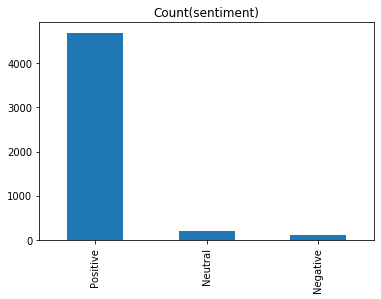

In [33]:
print(merge_df['sentiment'].value_counts())
merge_df['sentiment'].value_counts().plot(kind='bar', title="Count(sentiment)")
plt.show()

Completed Word Tokenization
Completed Removal of nltk StopWords
Completed Removal of Words of length = 1
Completed Joining of the cleaned Text into a record
Analysing Tokens:
Total Tokens: 76249


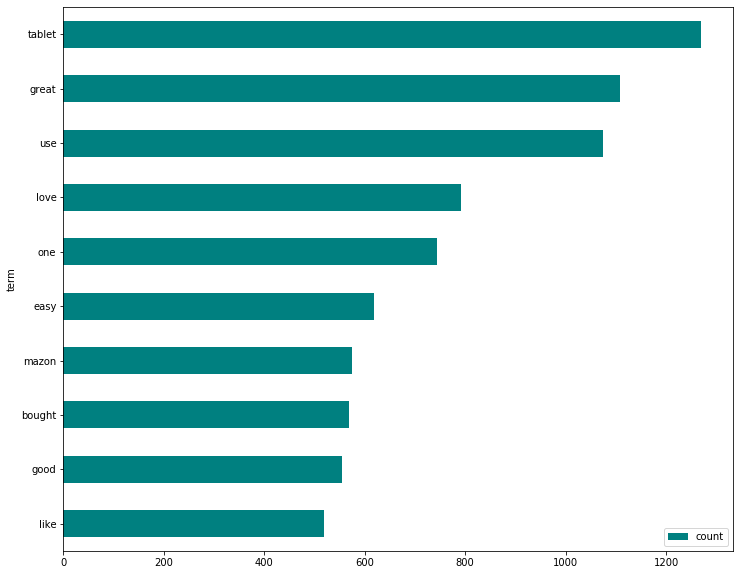

In [49]:
merge_df['review_cleaned'] = preprocess(merge_df['reviews.text'].tolist())

In [67]:
X, y = create_dataset(merge_df, 'reviews.text', 'sentiment')
len(X), len(y)

(5000, 5000)

In [68]:
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(X)
X_tfidf.shape

(5000, 5412)

In [78]:
X_train, X_test, y_train, y_test = create_train_test_datasets(X_tfidf, y)

In [81]:
print(X_train.shape)
print(X_test.shape)

(3500, 5412)
(1500, 5412)


In [85]:
multi_nb = create_model(X_train, y_train, MultinomialNB())

In [87]:
print(classification_report(y_test, multi_nb.predict(X_test), digits=4))

              precision    recall  f1-score   support

    Negative     0.0000    0.0000    0.0000        29
     Neutral     0.0000    0.0000    0.0000        79
    Positive     0.9280    1.0000    0.9627      1392

    accuracy                         0.9280      1500
   macro avg     0.3093    0.3333    0.3209      1500
weighted avg     0.8612    0.9280    0.8933      1500



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test), digits=4))

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_features=3000)
vect = CountVectorizer(max_features=3000)
tfidf = TfidfTransformer()
over = RandomOverSampler()
under = RandomUnderSampler()

In [ ]:
os_rf_clf = RandomForestClassifier()

pipeline = Pipeline(steps=[('tfidf_vect', tfidf_vect),
                            ('over', over),
                            ('clf', os_rf_clf)])
pipeline.fit(X_train,y_train)

In [ ]:
#transforming the test set
X_test_sampler = tfidf_vect.fit_transform(X_test)
X_test_sampler.shape

In [ ]:
print(classification_report(y_test, os_rf_clf.predict(X_test_sampler), digits=4))

In [ ]:
us_rf_clf = RandomForestClassifier()

pipeline = Pipeline(steps=[('tfidf_vect', tfidf_vect),
                            ('under', under),
                            ('clf', us_rf_clf)])
pipeline.fit(X_train,y_train)

In [ ]:
print(classification_report(y_test, us_rf_clf.predict(X_test_sampler), digits=4))

In [ ]:
from xgboost import XGBClassifier

In [ ]:
#Over Sampled XGBClassifier
os_xgb_clf = XGBClassifier()

pipeline = Pipeline(steps=[('tfidf_vect', tfidf_vect),
                            ('over', over),
                            ('clf', os_xgb_clf)])
pipeline.fit(X_train,y_train)

In [ ]:
print(classification_report(y_test, os_xgb_clf.predict(X_test_sampler), digits=4))

In [ ]:
#Over Sampled XGBClassifier
us_xgb_clf = XGBClassifier()

pipeline = Pipeline(steps=[('tfidf_vect', tfidf_vect),
                            ('under', under),
                            ('clf', us_xgb_clf)])
pipeline.fit(X_train,y_train)

In [ ]:
print(classification_report(y_test, us_xgb_clf.predict(X_test_sampler), digits=4))

In [ ]:
create_environment()